In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
import time
np.random.seed(0)

## 1. Problem statement

We condider the classical supervised learning problem:
$$y = X \omega + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2 I) $$

We aim to estimate weights $\omega$ and evaluate generalization.

## 2. Goal of the notebook

- Understand linear regression from first priciples;
- implement Ordinary Least Squares (OLS) both  analitically and with Gradient Descent (GD);
- derive and implement Ridge and Lasso regression;
- use cross-validation to choose regularization strengths;
- compare mehods through expiriment;
- analyze bias-variance trade-off.

## 3. Implementation

### 3.1 Data Generation

In this notebook synthetic data generation will be used. First, let's define some utility functions.

In [44]:
def train_val_test_split(X, y, train_frac=0.6, val_frac=0.2, test_frac=0.2, shuffle=True):
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    train_idx = idx[:n_train]
    val_idx = idx[n_train:n_train + n_val]
    test_idx = idx[n_train + n_val:]
    return X[train_idx], y[train_idx], X[val_idx], y[val_idx], X[test_idx], y[test_idx]

def add_bias(X):
    return np.concatenate([np.ones((X.shape[0],1)), X], axis=1)

We generate a synthetic linear dataset with controllable condition number and noise. This allows testing numerical stability, overfitting, and regularization behavior.

In [45]:
def generate_linear_data(n_samples=500, n_features=20, n_informative=5, noise_std=1.0, coef_scale=1.0, correlation=0.0):
    X = np.random.randn(n_samples, n_features)
    if correlation != 0.0:
        latent = np.random.randn(n_samples, 1)
        X = (1-correlation) * X + correlation * latent @ np.ones((1, n_features))
    w_true = np.zeros(n_features)
    informative_idx = np.arange(n_informative)
    w_true[informative_idx] = coef_scale * (np.random.randn(n_informative) * 2.0)
    y = X.dot(w_true) + noise_std * np.random.randn(n_samples)
    return X, y, w_true

X, y, w_true = generate_linear_data(n_samples=800, n_features=30, n_informative=7, noise_std=2.0, coef_scale=1.5)
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, train_frac=0.6, val_frac=0.2, test_frac=0.2)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


Shapes: (480, 30) (160, 30) (160, 30)


### 3.2 Ordinary Least Squares

#### 1. Closed-form

The idea is to minimize empirical squared loss

$L(w) = \dfrac{1}{n}\|X w - y\|^2.$

Closed-form solution (with bias term included):

$\hat w = (X^\top X)^{-1} X^\top y.$

To be numerically stable, we use pseudo-inverse or add small ridge if needed.


In [46]:
def ols_closed_form(X, y, add_intercept=True, ridge_eps=0.0):
    if add_intercept:
        Xb = add_bias(X)
    else:
        Xb = X
    n_features = Xb.shape[1]
    A = Xb.T.dot(Xb) + ridge_eps * np.eye(n_features)
    b = Xb.T.dot(y)
    w = np.linalg.solve(A, b)
    return w

def predict(X, w, add_intercept=True):
    if add_intercept:
        Xb = add_bias(X)
    else:
        Xb = X
    return Xb.dot(w)

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

w_ols = ols_closed_form(X_train, y_train, add_intercept=True, ridge_eps=0.0)
y_val_pred = predict(X_val, w_ols)
print("OLS val MSE:", mse(y_val, y_val_pred))


OLS val MSE: 4.4576257941209505


#### 2. OLS via Gradient Descent
We implement gradient descent for the squared loss:

$\nabla_w L(w) = \dfrac{2}{n} X^\top (X w - y).$

We will use the bias included in X.


In [47]:
def ols_gd(X, y, lr=0.01, max_iter=1000, tol=1e-8, add_intercept=True, verbose=False):
    if add_intercept:
        Xb = add_bias(X)
    else:
        Xb = X
    n = Xb.shape[0]
    p = Xb.shape[1]
    w = np.zeros(p)
    history = []
    for t in range(max_iter):
        grad = (2.0/n) * Xb.T.dot(Xb.dot(w) - y)
        w = w - lr * grad
        loss = np.mean((Xb.dot(w) - y)**2)
        history.append(loss)
        if np.linalg.norm(grad) < tol:
            if verbose:
                print("Converged at iteration", t)
            break
    return w, np.array(history)

w_gd, hist_gd = ols_gd(X_train, y_train, lr=0.001, max_iter=5000)
print("GD final train MSE:", mse(y_train, predict(X_train, w_gd)))
print("GD val MSE:", mse(y_val, predict(X_val, w_gd)))


GD final train MSE: 3.6464208812330767
GD val MSE: 4.458846881435756


### 3.3 Ridge Regression (L2 regularization)

We want to minimize $L_\lambda(w) = \dfrac{1}{n}\|X w - y\|^2 + \lambda \|w\|_2^2.$

Closed-form solution is 

$\hat w_\text{ridge} = (X^\top X + n\lambda I)^{-1} X^\top y.$


In [48]:
def ridge_closed_form(X, y, lam=1.0, add_intercept=True):
    if add_intercept:
        Xb = add_bias(X)
    else:
        Xb = X
    n = Xb.shape[0]
    p = Xb.shape[1]
    if add_intercept:
        I = np.eye(p)
        I[0,0] = 0.0
    else:
        I = np.eye(p)
    A = Xb.T.dot(Xb) + n * lam * I
    b = Xb.T.dot(y)
    w = np.linalg.solve(A, b)
    return w

def ridge_gd(X, y, lam=1.0, lr=0.01, max_iter=1000, add_intercept=True):
    if add_intercept:
        Xb = add_bias(X)
    else:
        Xb = X
    n = Xb.shape[0]
    p = Xb.shape[1]
    w = np.zeros(p)
    history = []
    for t in range(max_iter):
        grad = (2.0/n) * Xb.T.dot(Xb.dot(w) - y) + 2.0 * lam * np.r_[0.0, w[1:]] if add_intercept else \
               (2.0/n) * Xb.T.dot(Xb.dot(w) - y) + 2.0 * lam * w
        w = w - lr * grad
        history.append(np.mean((Xb.dot(w) - y)**2 + lam * np.sum(w[1:]**2)) if add_intercept else np.mean((Xb.dot(w)-y)**2 + lam*np.sum(w**2)))
    return w, np.array(history)

w_ridge = ridge_closed_form(X_train, y_train, lam=1.0)
print("Ridge val MSE (lam=1):", mse(y_val, predict(X_val, w_ridge)))


Ridge val MSE (lam=1): 20.91307478199837


### 3.3 Lasso Regression (L1 regularization)

Now we minimize $L_\lambda(w) = \dfrac{1}{n}\|X w - y\|^2 + \lambda \|w\|_1.$

Lasso encourages sparse solutions. There is no closed-form solution; we implement coordinate descent using soft-thresholding.

Soft-threshold operator: $S(z, \gamma) = \text{sign}(z)\max(|z| - \gamma, 0).$


In [49]:
def soft_threshold(z, gamma):
    return np.sign(z) * np.maximum(np.abs(z) - gamma, 0.0)

def lasso_coordinate_descent(X, y, lam=1.0, max_iter=1000, tol=1e-6, add_intercept=True):
    if add_intercept:
        Xb = add_bias(X)
    else:
        Xb = X
    n, p = Xb.shape
    w = np.zeros(p)
    for _ in range(max_iter):
        w_old = w.copy()
        for j in range(p):
            if add_intercept and j == 0:
                residual = y - Xb.dot(w) + w[0] * Xb[:,0]
                w[0] = np.mean(residual)
            else:
                residual = y - Xb.dot(w) + w[j] * Xb[:,j]
                rho = Xb[:,j].dot(residual)
                z = Xb[:,j].dot(Xb[:,j])
                w[j] = soft_threshold(rho / z, lam * n / z)
        if np.linalg.norm(w - w_old) < tol:
            break
    return w

w_lasso = lasso_coordinate_descent(X_train, y_train, lam=0.5)
print("Lasso val MSE:", mse(y_val, predict(X_val, w_lasso)))


Lasso val MSE: 7.177670668476054


### 3.4 K-fold Cross-Validation utility

We implement a simple k-fold cross-validation routine to evaluate hyperparameters ($\lambda$, learning rate etc.).


In [50]:
def k_fold_indices(n, k=5, shuffle=True):
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    folds = np.array_split(idx, k)
    return folds

def cross_val_score_closed_form(model_fn, X, y, k=5, **kwargs):
    n = X.shape[0]
    folds = k_fold_indices(n, k=k, shuffle=True)
    val_scores = []
    for i in range(k):
        val_idx = folds[i]
        train_idx = np.hstack([folds[j] for j in range(k) if j != i])
        Xt, yt = X[train_idx], y[train_idx]
        Xv, yv = X[val_idx], y[val_idx]
        w = model_fn(Xt, yt, **kwargs)
        y_pred = predict(Xv, w)
        val_scores.append(mse(yv, y_pred))
    return np.mean(val_scores), np.std(val_scores)

def model_ridge_wrapper(Xt, yt, lam=1.0):
    return ridge_closed_form(Xt, yt, lam=lam)

def model_ols_wrapper(Xt, yt):
    return ols_closed_form(Xt, yt)

def grid_search_ridge(X, y, lam_list, k=5):
    results = []
    for lam in lam_list:
        mean_val, std_val = cross_val_score_closed_form(model_ridge_wrapper, X, y, k=k, lam=lam)
        results.append({"lam": lam, "mean_val": mean_val, "std_val": std_val})
    results = sorted(results, key=lambda r: r["mean_val"])
    return results


### 3.5 Hyperparameter search

We search $\lambda$ for Ridge and Lasso using k-fold cross-validation.


In [51]:
lam_list = np.logspace(-4, 2, 20)

ridge_results = grid_search_ridge(X_train, y_train, lam_list, k=5)

def cross_val_score_lasso(X, y, lam, k=5, max_iter=1000):
    n = X.shape[0]
    folds = k_fold_indices(n, k=k, shuffle=True)
    val_scores = []
    for i in range(k):
        val_idx = folds[i]
        train_idx = np.hstack([folds[j] for j in range(k) if j != i])
        Xt, yt = X[train_idx], y[train_idx]
        Xv, yv = X[val_idx], y[val_idx]
        w = lasso_coordinate_descent(Xt, yt, lam=lam, max_iter=max_iter)
        y_pred = predict(Xv, w)
        val_scores.append(mse(yv, y_pred))
    return np.mean(val_scores), np.std(val_scores)

lasso_results = []
for lam in lam_list:
    mean_val, std_val = cross_val_score_lasso(X_train, y_train, lam=lam, k=5, max_iter=500)
    lasso_results.append({"lam": lam, "mean_val": mean_val, "std_val": std_val})
lasso_results = sorted(lasso_results, key=lambda r: r["mean_val"])

### 3.6 Evaluation of best models

After suitable hyperparameters were found we take the best $\lambda$ from cross-validation for Ridge and Lasso, then fit on train + val and, finally, evaluate on test.

In [52]:
best_ridge_lam = ridge_results[0]["lam"]
best_lasso_lam = lasso_results[0]["lam"]
print("Selected ridge lam:", best_ridge_lam, "selected lasso lam:", best_lasso_lam)

X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

w_ridge_best = ridge_closed_form(X_trainval, y_trainval, lam=best_ridge_lam)
w_lasso_best = lasso_coordinate_descent(X_trainval, y_trainval, lam=best_lasso_lam, max_iter=1000)
w_ols_full = ols_closed_form(X_trainval, y_trainval)

print("Test MSE OLS:", mse(y_test, predict(X_test, w_ols_full)))
print("Test MSE Ridge:", mse(y_test, predict(X_test, w_ridge_best)))
print("Test MSE Lasso:", mse(y_test, predict(X_test, w_lasso_best)))


Selected ridge lam: 0.0008858667904100823 selected lasso lam: 0.03359818286283781
Test MSE OLS: 3.779313027937755
Test MSE Ridge: 3.777440752035448
Test MSE Lasso: 3.6636074464939385


### 3.7 Visalization

In this block we will compare true vs estimated coefficients, and prediction quality by visualizing results.


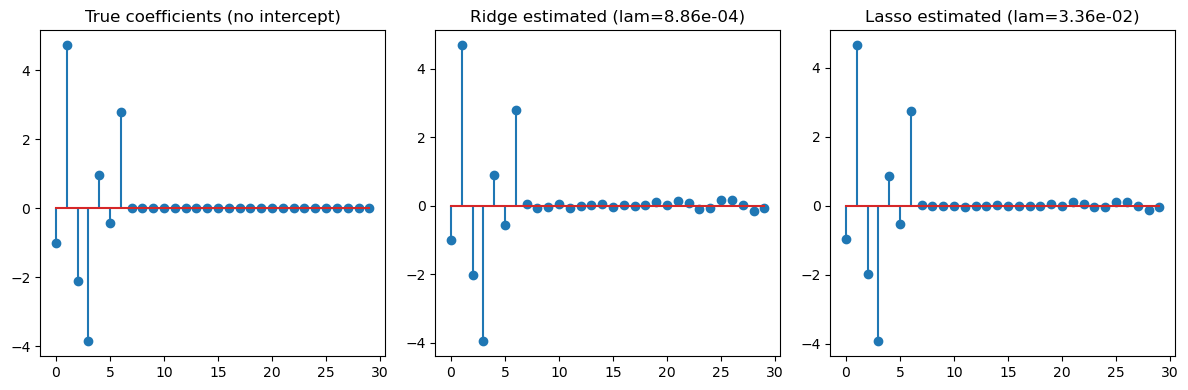

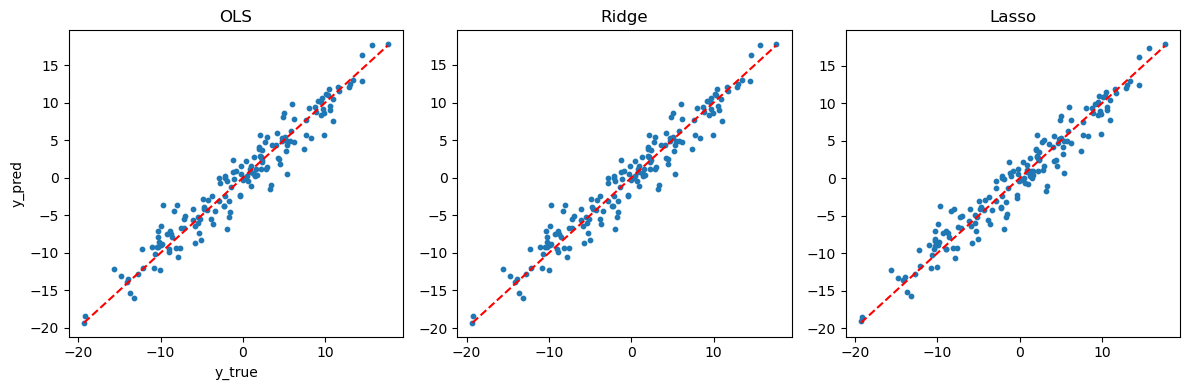

In [53]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.stem(w_true)
plt.title("True coefficients (no intercept)")
plt.subplot(132)
plt.stem(w_ridge_best[1:])
plt.title(f"Ridge estimated (lam={best_ridge_lam:.2e})")
plt.subplot(133)
plt.stem(w_lasso_best[1:])
plt.title(f"Lasso estimated (lam={best_lasso_lam:.2e})")
plt.tight_layout()
plt.show()

y_pred_ols = predict(X_test, w_ols_full)
y_pred_ridge = predict(X_test, w_ridge_best)
y_pred_lasso = predict(X_test, w_lasso_best)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.scatter(y_test, y_pred_ols, s=10); plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.title("OLS")
plt.xlabel("y_true"); plt.ylabel("y_pred")
plt.subplot(132)
plt.scatter(y_test, y_pred_ridge, s=10); plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.title("Ridge")
plt.subplot(133)
plt.scatter(y_test, y_pred_lasso, s=10); plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.title("Lasso")
plt.tight_layout()
plt.show()


### 3.8 Bias-varience decomposition

Bias and variance are estimated through repeated sampling. We generate a number of datasets from the same data generation process, fit models and compute mean prediction and variance at test points.

In [54]:
def bias_variance_decomp(generate_fn, fit_fn, predict_fn, n_repeat=100, n_test=200, **fit_kwargs):
    preds = []
    y_tests = []
    for i in range(n_repeat):
        Xr, yr, Xt, yt = generate_fn()
        w = fit_fn(Xr, yr, **fit_kwargs)
        pred = predict_fn(Xt, w)
        preds.append(pred)
        y_tests.append(yt)
    preds = np.array(preds) 
    y_tests = np.array(y_tests) 
    y_true_avg = np.mean(y_tests, axis=0)
    bias2 = np.mean((np.mean(preds, axis=0) - y_true_avg)**2)
    variance = np.mean(np.var(preds, axis=0))
    mse_total = np.mean(np.mean((preds - y_tests)**2, axis=1))
    noise = mse_total - bias2 - variance
    return {"mse": mse_total, "bias2": bias2, "variance": variance, "noise": noise}

def make_generator(n_samples=200, n_features=30, n_informative=7, noise_std=2.0):
    Xt, yt, _ = generate_linear_data(n_samples, n_features, n_informative, noise_std)
    def gen():
        Xr, yr, _ = generate_linear_data(n_samples, n_features, n_informative, noise_std)
        return Xr, yr, Xt, yt
    return gen

gen = make_generator(n_samples=200, n_features=30, n_informative=7, noise_std=2.0)

bv_ols = bias_variance_decomp(gen, lambda X,y: ols_closed_form(X,y), predict, n_repeat=60)
bv_ridge = bias_variance_decomp(gen, lambda X,y,lam=1.0: ridge_closed_form(X,y,lam=lam), predict, n_repeat=60, lam=1.0)
bv_lasso = bias_variance_decomp(gen, lambda X,y,lam=best_lasso_lam: lasso_coordinate_descent(X,y,lam=lam), predict, n_repeat=60, lam=best_lasso_lam)

print("OLS BV:")
print(*[f"{k}: {v}" for k, v in bv_ols.items()], sep="\n")
print("\n")
print("Ridge BV:")
print(*[f"{k}: {v}" for k, v in bv_ridge.items()], sep="\n")
print("\n")
print("Lasso BV:")
print(*[f"{k}: {v}" for k, v in bv_lasso.items()], sep="\n")



OLS BV:
mse: 60.62554344695446
bias2: 29.998288748372726
variance: 30.627254698581737
noise: -3.552713678800501e-15


Ridge BV:
mse: 37.738375862489214
bias2: 30.1226784826321
variance: 7.615697379857107
noise: 7.105427357601002e-15


Lasso BV:
mse: 57.95956622331936
bias2: 30.007163059638906
variance: 27.952403163680454
noise: -3.552713678800501e-15


## Conclusion

In this project we conducted a complete study for linear statistical learning methods, starting from classical Ordinary Least Squares estimators and continuing with regularized Ridge and Lasso regressions. Every method is implemented from scratch and evaluated on synthetic data with consistent methodology, theoretical foundations are shown.